In [1]:
from TableTennisEnvironmentV0.TableTennisEnvironment import TableTennisEnv
from utils.BotPluginMoveIt import BotPluginMoveIt
import pybullet as p
import numpy as np
import time
import joblib
from utils.physics_solvers import estimateInitVelocity, estimate_hitting_point, calculate_delta, had_double_bounce, had_no_bounce
import math
import torch
import torch.nn as nn
import torch.optim as optim
from delta_estimator_mlp.DeltaEstimatorMLP import DeltaEstimatorMLP
import random

pybullet build time: Nov 28 2023 23:51:11


Predicted Output: [-0.2558609 -1.5050874]


/home/n3r0/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
env = TableTennisEnv(show_gui=True)

In [3]:
moveit_plugin = BotPluginMoveIt(environment = env)

[ERROR] [1718758444.288550505]: Group 'paddle_group' for end-effector 'paddle' cannot be its own parent
[ WARN] [1718758444.741257331]: The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
[ WARN] [1718758444.962075270]: The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.
[ WARN] [1718758445.116337767]: The root link base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.


In [4]:

def find_best_plan_and_execute(xt, yt, zt):
    moveit_plugin.plan_motion(x = xt,
                              y = yt,## This goal position denotes the intercept point
                              z = zt - 1.25,
                              roll = 0,
                              pitch = 0,
                              yaw = np.pi/2)
    # plan1 = moveit_plugin.plan
    # plan1_trajectory = plan1[1].joint_trajectory.points
    
    # moveit_plugin.plan_motion(x = xt,
    #                           y = yt,## This goal position denotes the intercept point
    #                           z = zt - 1.25,
    #                           roll = 0,
    #                           pitch = 0,
    #                           yaw = -np.pi/2)
    # plan2 = moveit_plugin.plan
    # plan2_trajectory = plan2[1].joint_trajectory.points
    # if len(plan1_trajectory)< len(plan2_trajectory):
    #     moveit_plugin.plan = plan1
    # else:
    #     moveit_plugin.plan = plan2
    moveit_plugin.execute_plan()


find_best_plan_and_execute(-0.4, -0.5, 1.7)

In [5]:
# Load the scaler
scaler = joblib.load('delta_estimator_mlp/scaler.pkl')

# Parameters
input_size = 9  # Number of input features
hidden_size = 32  # Number of neurons in the hidden layer
output_size = 2  # Number of output features (delta_y, delta_z)

# Create model and load trained weights
model = DeltaEstimatorMLP(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('delta_estimator_mlp/delta_estimator_mlp.pth'))
model.eval()

# Sample inference code
def calculate_delta_v2(input_features):
    # Convert input features to tensor
    input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    # Perform inference
    with torch.no_grad():
        prediction = model(input_tensor)

    # print(prediction)
    # Inverse transform the prediction to get original values
    prediction_original = scaler.inverse_transform(prediction.numpy())
    
    return prediction_original[0]

# Example input features for inference
sample_input = np.array([
    0.5, 0.5, 0.5,  # ball_initial_pos_x, ball_initial_pos_y, ball_initial_pos_z
    1.0,  # distance_ball_robot
    0.1, 0.1, 0.1,  # estimated_initial_velocity_x, estimated_initial_velocity_y, estimated_initial_velocity_z
    0.2, 0.2  # estimated_hitting_point_y, estimated_hitting_point_z
])

# Perform inference and print the result
predicted_output = calculate_delta_v2(sample_input)
print("Predicted Output:", predicted_output)

Predicted Output: [-0.2558609 -1.5050874]


/home/n3r0/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
def find_goal_position():
    ball_position1 = ball_initial_position = p.getBasePositionAndOrientation(env._ball)[0]
    robot_initial_position = p.getLinkState(env._robotic_arm, 0)[0]      # can be collected from optitrack
    distance = robot_initial_position[0] - ball_initial_position[0]
    action = [0, 0, 0, 0, 0, 0]
    env.step(action)
    ball_position2 = p.getBasePositionAndOrientation(env._ball)[0]
    table_height = 1.0
    estimated_initial_velocity = estimateInitVelocity(ball_position1, ball_position2, 1/240)
    estimated_hitting_point, t1, t2 = estimate_hitting_point(ball_initial_position, robot_initial_position, estimated_initial_velocity, table_height)
    input_for_delta = [ball_initial_position[0], 
                       ball_initial_position[1], 
                       ball_initial_position[2], 
                       distance, 
                       estimated_initial_velocity[0], 
                       estimated_initial_velocity[1], 
                       estimated_initial_velocity[2], 
                       estimated_hitting_point[0], 
                       estimated_hitting_point[1]]
    delta = calculate_delta_v2(np.asarray(input_for_delta))
    return estimated_hitting_point+delta, estimated_initial_velocity

In [7]:
def check_collision(body1, body2):
    contacts = p.getContactPoints(body1, body2)
    return len(contacts)>0

In [8]:
BALL_IS_THROWN = 0
BALL_HIT_THE_PADDLE = 1
BALL_HIT_THE_TABLE = 2

In [9]:
# import csv
# with open('hitting_vel_training_dataset.csv', mode='w', newline='') as file:
#     writer = csv.writer(file)
#     # Write the header
#     writer.writerow([
#         "ball_init_position_x", 
#         "ball_init_position_y", 
#         "ball_init_position_z",
#         "estimated_init_vel_x", 
#         "estimated_init_vel_y", 
#         "estimated_init_vel_z",
#         "goal_position_y", 
#         "goal_position_z",
#         "table_hit_point_x", 
#         "table_hit_point_y", 
#         "table_hit_point_z",
#         "paddle_hitting_vel_joint3", 
#         "paddle_hitting_vel_joint4", 
#         "paddle_hitting_vel_joint5"
#     ])

In [9]:
import csv
with open('hitting_vel_training_dataset.csv', mode='a', newline='') as file:
    writer = csv.writer(file)
    
    
    for vel in range(1000):
        
        ball_init_position = [-1.4, -0.2, 2.1]
        real_initial_velocity = [random.uniform(6.5, 8.0), random.uniform(-0.3, 0.0), random.uniform(-2, -3)]
        paddle_hitting_vel = [random.uniform(-20, 20), random.uniform(-20, 20), random.uniform(10, 20)]
        
        p.removeBody(env._table_body_id) # removing the old table
        table_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=[1.37, 0.75, 0.5])
        table_visual_id = -1
        env._table_body_id = p.createMultiBody(baseMass=20000.0, baseCollisionShapeIndex=table_id, baseVisualShapeIndex=table_visual_id, basePosition=[0, 0, 0.7])
        p.changeDynamics(env._table_body_id, -1, restitution=0.8, lateralFriction = 0.5)  # Adjust the restitution as needed (e.g., 0.8 for a good bounce)
        # p.removeBody(env._ball)
        env.get_new_ball(position=ball_init_position)
        # p.changeDynamics(env._ball, -1, restitution = 0.8)
        env.throw_ball(real_initial_velocity)
        state = BALL_IS_THROWN
        distance_ball_robot = p.getLinkState(env._robotic_arm, 0)[0][0] - ball_init_position[0]
        goal_position, estimated_init_vel = find_goal_position()
        # goal_position = goal_position[0]
        find_best_plan_and_execute(xt = -0.5,
                                  yt = goal_position[0],
                                  zt = goal_position[1],
                                  )
        
        for _ in range(500):
            if state == BALL_IS_THROWN and check_collision(env._ball, env._robotic_arm):
                state = BALL_HIT_THE_PADDLE
                p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                        jointIndex=3,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=paddle_hitting_vel[0],
                                       )
        
                p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                        jointIndex=4,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=paddle_hitting_vel[1],
                                       )
                p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                        jointIndex=5,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=paddle_hitting_vel[2],
                                       )
        
                
        
                for hitting_time in range(10):
                    p.stepSimulation()
                    time.sleep(1/500)
        
                p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                            jointIndex=3,
                                            controlMode=p.VELOCITY_CONTROL,
                                            targetVelocity=0,
                                           )
                
                p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                            jointIndex=4,
                                            controlMode=p.VELOCITY_CONTROL,
                                            targetVelocity=0,
                                           )
                p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                            jointIndex=5,
                                            controlMode=p.VELOCITY_CONTROL,
                                            targetVelocity=0,
                                           )
            p.stepSimulation()
            time.sleep(1/500)
        
        
            if state == BALL_HIT_THE_PADDLE and check_collision(env._ball, env._table_body_id):
                table_hit_point = env.get_state()['ball']['position']
                print(table_hit_point)
                # param1.append(real_initial_velocity[0])
                # param2.append(table_hit_point[1])
                # save = input('wanna save the experiment?')
                # if save == 'y':
                writer.writerow([
                    ball_init_position[0], 
                    ball_init_position[1], 
                    ball_init_position[2],
                    estimated_init_vel[0], 
                    estimated_init_vel[1], 
                    estimated_init_vel[2],
                    goal_position[0], 
                    goal_position[1],
                    table_hit_point[0], 
                    table_hit_point[1], 
                    table_hit_point[2],
                    paddle_hitting_vel[0], 
                    paddle_hitting_vel[1], 
                    paddle_hitting_vel[2]
                ])
                break


print('done')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4297edeb80>>
Traceback (most recent call last):
  File "/home/n3r0/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4297edeb80>>
Traceback (most recent call last):
  File "/home/n3r0/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 

KeyboardInterrupt



### Relation with table pos vs joint angular velocity

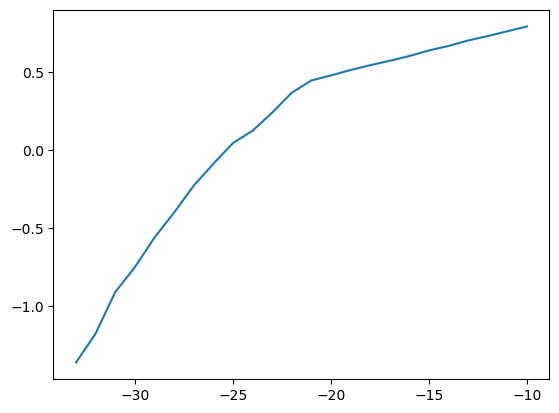

In [57]:
import matplotlib.pyplot as plt
plt.plot(hitting_vel, table_pos)

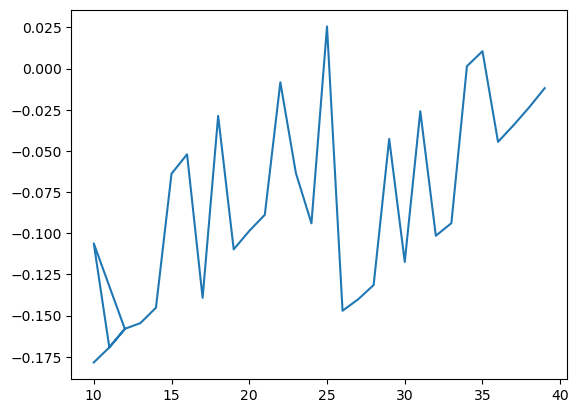

In [66]:
import matplotlib.pyplot as plt
plt.plot(hitting_vel, table_pos)

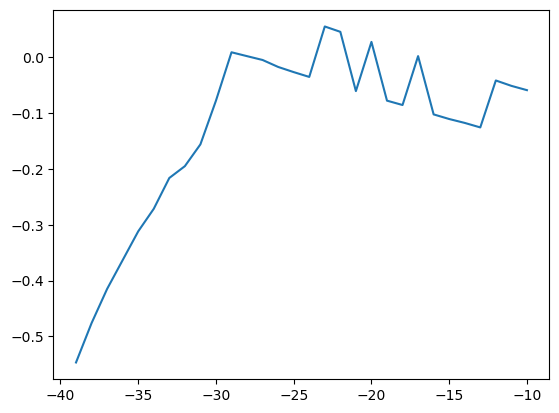

In [74]:
import matplotlib.pyplot as plt
plt.plot(hitting_vel, table_pos)

### relation with ball initial x velocity with position x in table

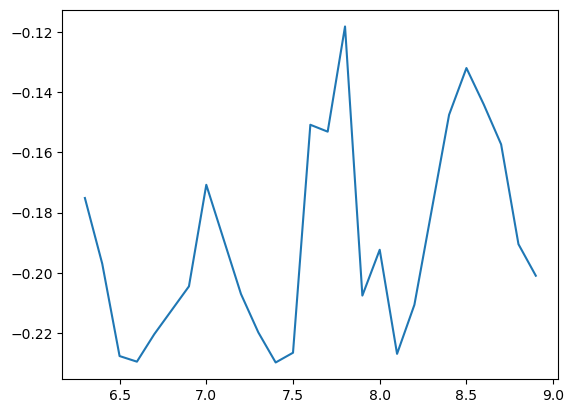

In [13]:
import matplotlib.pyplot as plt
plt.plot(param1, param2)

## Inference

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import joblib

hitting_model = joblib.load('random_forest_model.pkl')
# Load the scaler objects
scaler_X = joblib.load('scalerX.pkl')
scaler_y = joblib.load('scalery.pkl')
input_columns = [
    'estimated_init_vel_x', 
    'estimated_init_vel_y', 
    'estimated_init_vel_z',
    'goal_position_y', 
    'goal_position_z',
    'table_hit_point_x', 
    'table_hit_point_y',
    # 'table_hit_point_z'
]
# Function to make a prediction
def plan_hitting_velocity(input_data):
    # Convert input data to DataFrame
    input_df = pd.DataFrame(input_data, columns=input_columns)
    
    # Scale the input data
    input_scaled = scaler_X.transform(input_df.values)
    
    # Make predictions
    prediction_scaled = hitting_model.predict(input_scaled)
    
    # Inverse transform the scaled predictions
    prediction = scaler_y.inverse_transform(prediction_scaled)
    
    return prediction

/home/n3r0/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/n3r0/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.5.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/n3r0/.local/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.0 when using version 1.3.2. This

In [12]:
intended_table_hit_point = [0.22, -0.42]
for vel in range(1000):
    
    ball_init_position = [-1.4, -0.2, 2.1]
    real_initial_velocity = [random.uniform(6.5, 8.0), random.uniform(-0.3, 0.3), random.uniform(-2, -3)]
    # paddle_hitting_vel = [random.uniform(-20, 20), random.uniform(-20, 20), random.uniform(10, 20)]
    
    p.removeBody(env._table_body_id) # removing the old table
    table_id = p.createCollisionShape(p.GEOM_BOX, halfExtents=[1.37, 0.75, 0.5])
    table_visual_id = -1
    env._table_body_id = p.createMultiBody(baseMass=20000.0, baseCollisionShapeIndex=table_id, baseVisualShapeIndex=table_visual_id, basePosition=[0, 0, 0.7])
    p.changeDynamics(env._table_body_id, -1, restitution=0.8, lateralFriction = 0.5)  # Adjust the restitution as needed (e.g., 0.8 for a good bounce)
    # p.removeBody(env._ball)
    env.get_new_ball(position=ball_init_position)
    # p.changeDynamics(env._ball, -1, restitution = 0.8)
    env.throw_ball(real_initial_velocity)
    state = BALL_IS_THROWN
    distance_ball_robot = p.getLinkState(env._robotic_arm, 0)[0][0] - ball_init_position[0]
    goal_position, estimated_init_vel = find_goal_position()
    # goal_position = goal_position[0]
    find_best_plan_and_execute(xt = -0.5,
                              yt = goal_position[0],
                              zt = goal_position[1],
                              )
    
    for _ in range(500):
        if state == BALL_IS_THROWN and check_collision(env._ball, env._robotic_arm):
            state = BALL_HIT_THE_PADDLE

            
            hitting_model_input = np.array([[
                estimated_init_vel[0],
                estimated_init_vel[1],
                estimated_init_vel[2],
                goal_position[0],
                goal_position[1],
                intended_table_hit_point[0],
                intended_table_hit_point[1],
            ]])

            paddle_hitting_vel = plan_hitting_velocity(hitting_model_input)[0]
            p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                    jointIndex=3,
                                    controlMode=p.VELOCITY_CONTROL,
                                    targetVelocity=paddle_hitting_vel[0],
                                   )
    
            p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                    jointIndex=4,
                                    controlMode=p.VELOCITY_CONTROL,
                                    targetVelocity=paddle_hitting_vel[1],
                                   )
            p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                    jointIndex=5,
                                    controlMode=p.VELOCITY_CONTROL,
                                    targetVelocity=paddle_hitting_vel[2],
                                   )
    
            
    
            for hitting_time in range(10):
                p.stepSimulation()
                time.sleep(1/500)
    
            p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                        jointIndex=3,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=0,
                                       )
            
            p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                        jointIndex=4,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=0,
                                       )
            p.setJointMotorControl2(bodyIndex=env._robotic_arm,
                                        jointIndex=5,
                                        controlMode=p.VELOCITY_CONTROL,
                                        targetVelocity=0,
                                       )
        p.stepSimulation()
        time.sleep(1/500)
    
    
        if state == BALL_HIT_THE_PADDLE and check_collision(env._ball, env._table_body_id):
            table_hit_point = env.get_state()['ball']['position']
            print(table_hit_point)
            # param1.append(real_initial_velocity[0])
            # param2.append(table_hit_point[1])
            # save = input('wanna save the experiment?')
            # if save == 'y':
            
            break


print('done')

(0.052203420566005396, -0.4375557839091374, 1.2237461436536956)
(0.3051637932861282, -0.4881063342871017, 1.2231261608599466)
(0.22725684186610362, -0.385639021879793, 1.2282069725948694)
(0.33436588167806014, -0.3441171658880896, 1.2263746868376193)
(0.32407076705939786, -0.505136773239238, 1.2250962950173212)
(0.1200227499266232, -0.4646565383059323, 1.2266235467534419)
(0.3906171002875953, -0.4580973202049163, 1.2275961003398468)


[ERROR] [1718758796.306744074]: Got a callback on a goalHandle that we're not tracking.                 This is an internal SimpleActionClient/ActionClient bug.                 This could also be a GoalID collision


(0.32941800577292263, -0.3099468581015735, 1.2318655158841305)
(0.22570029063171218, -0.27923540497934796, 1.2231007624217358)
(0.14866928432433835, -0.39694145398667824, 1.2219816418821887)
(0.11528118264139055, -0.4846612323671387, 1.2212883449059544)


KeyboardInterrupt: 